In [7]:
# Adapted from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
from tqdm import tqdm_notebook as tqdm
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [16]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mnist_experiment_fc')

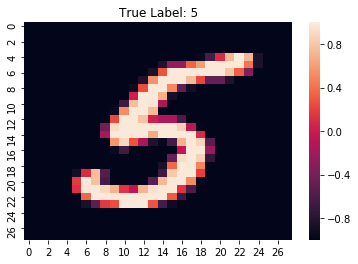

In [19]:
from sklearn.preprocessing import StandardScaler

def normalize_mnist(x):
    return x * 2 - 1

# MNIST Test dataset and dataloader declaration
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize_mnist
            ])),
        batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize_mnist
            ])),
        batch_size=1, shuffle=True)

import seaborn as sns
_, (images, labels) = next(enumerate(train_loader, 0))
text_index = 0
im, label = images[text_index, 0, :, :].numpy(), labels[text_index].item()
plt.title(f"True Label: {label}")
sns.heatmap(im)
plt.savefig("MNIST_Example.png")

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)
writer.add_image('four_fashion_mnist_images', img_grid)

In [27]:
class NamedModel(nn.Module):
    def __init__(self, model_name: str):
        super(NamedModel, self).__init__()
        self.name = model_name

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 28 * 14)
        self.fc2 = nn.Linear(28 * 14, 28 * 8)
        self.output = nn.Linear(28 * 8, 10)
        
    def forward(self, x):
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return F.log_softmax(x)

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# Initialize the network
models = [FCNet().to(device), ConvNet().to(device)]
writer.add_graph(model, images.to(device))
writer.close()

C:\Users\rapha\Desktop\ai-trainer\envs\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [29]:
EPOCHS = 5
ts = [tqdm(total=len(train_loader), position=n) for n in range(EPOCHS)] 

for epoch in range(EPOCHS):
    
    running_loss, print_loss = 0.0, "-1."
    
    for batch_id, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        
        if batch_id > 0:
            print_loss = str(running_loss / batch_id)[:5]
            ts[epoch].update()
            ts[epoch].set_description(print_loss)
    running_loss = 0.0

C:\Users\rapha\Desktop\ai-trainer\envs\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  
C:\Users\rapha\Desktop\ai-trainer\envs\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [30]:
def fgsm_attack(image: torch.Tensor, epsilon: float, data_grad: torch.Tensor):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [40]:
def test(model: torch.nn, device: torch.device, test_loader: torch.utils.data.DataLoader, epsilon: float):
    wrong, correct, adv_success = 0, 0, 0
    adv_examples = []
    
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        
        data.requires_grad = True # This enables a gradient based attack such as fgsm
        
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        
        if init_pred.item() != target.item():
            wrong += 1
        else:
            # Prediction was correct, try to fool the network
            correct += 1
        
            loss = F.nll_loss(output, target)
            
            model.zero_grad()
            
            loss.backward()
        
            data_grad = data.grad.data
            
            perturbed_data = fgsm_attack(data, epsilon, data_grad)
            
            output = model(perturbed_data)
            
            adversarial_pred = output.max(1, keepdim=True)[1] # max returns a tuple (values, indices)
            if np.random.rand() > 0.9 or True:
                perturbed_arr = perturbed_data.detach().cpu().numpy()
                writer.add_image(f'Adversarial Example with Epsilon={epsilon}', perturbed_arr[0])
                adv_examples.append((target.item(), adversarial_pred.item(), perturbed_arr))
        
            if adversarial_pred.item() != target.item():
                adv_success += 1
    
    print(f'Correct: {correct}; Wrong: {wrong}')
    print(f'Adversarial Successes: {adv_success}')
    acc =  correct / (wrong + correct)
    return acc, adv_examples

C:\Users\rapha\Desktop\ai-trainer\envs\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """
C:\Users\rapha\Desktop\ai-trainer\envs\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Correct: 9517; Wrong: 483
Adversarial Successes: 416
Accuracy for epsilon=0: 0.9517

Correct: 9517; Wrong: 483
Adversarial Successes: 830
Accuracy for epsilon=0.05: 0.9517

Correct: 9517; Wrong: 483
Adversarial Successes: 1436
Accuracy for epsilon=0.1: 0.9517

Correct: 9517; Wrong: 483
Adversarial Successes: 2251
Accuracy for epsilon=0.15: 0.9517

Correct: 9517; Wrong: 483
Adversarial Successes: 3300
Accuracy for epsilon=0.2: 0.9517

Correct: 9517; Wrong: 483
Adversarial Successes: 4384
Accuracy for epsilon=0.25: 0.9517

Correct: 9517; Wrong: 483
Adversarial Successes: 5549
Accuracy for epsilon=0.3: 0.9517


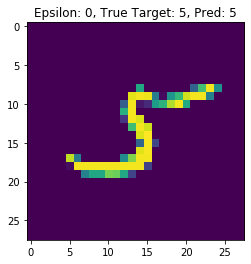

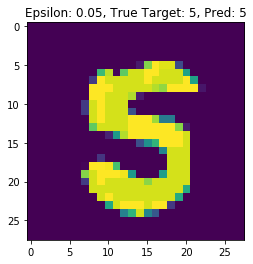

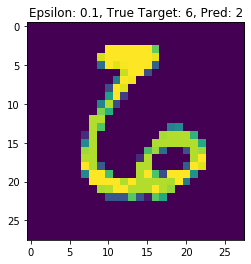

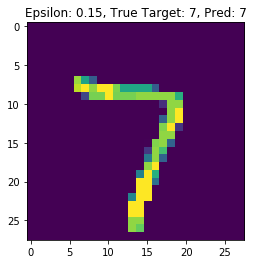

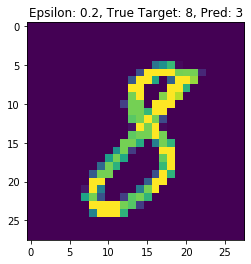

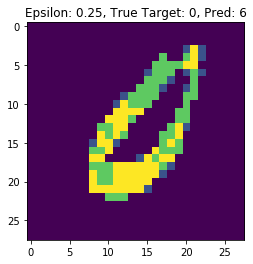

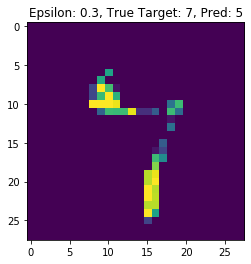

In [39]:
import random
epsilons = [0, .05, .1, .15, .2, .25, .3]
for epsilon in epsilons:
    acc, meta = test(model, device, test_loader, epsilon=epsilon)
    true_target, adv_pred, adv_ex = random.choice(meta)
    plt.title(f"Epsilon: {epsilon}, True Target: {true_target}, Pred: {adv_pred}")
    plt.imshow(adv_ex.squeeze())
    plt.show()
    print(f"Accuracy for epsilon={epsilon}: {acc}")


# Visualization of model weights

In [24]:
W = model.state_dict()

In [25]:
for key in W.keys():
    print(key)

fc1.weight
fc1.bias
fc2.weight
fc2.bias
output.weight
output.bias


In [26]:
arr = W['conv2.weight'].cpu().numpy()
print(arr.shape)
def vis_conv_weights(arr: np.ndarray):
    plt.title(f"Convolutional Weights")
    
    fig_width = 12.  # inches
    fig_height = 12.
    
    cmaps = ['Greens', 'plasma']
    
    f, axarr = plt.subplots(arr.shape[0], arr.shape[1], figsize=(fig_width, fig_height))
    for depth in range(arr.shape[0]):
        for channel in range(arr.shape[1]):
            plot_index = 1 + depth * arr.shape[1] + channel
            # print(f"ASDF: {plot_index}")
            im = arr[depth, channel, :, :]
            axarr[depth, channel].imshow(im, cmap=cmaps[depth % 2])
            axarr[depth, channel].axis('off')
            
            # plt.subplot(arr.shape[0], arr.shape[1], plot_index)
            # plt.imshow(arr[depth, channel, : , :])
    plt.savefig("weights.png")
    plt.show()
vis_conv_weights(arr)

KeyError: 'conv2.weight'